# Task 6
## Create and split training/testing datasets

### Import frameworks

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.layers import Input
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


### Load Dataset and split labels

In [3]:
df = pd.read_csv('Dyadic_PELD.tsv', sep='\t', header=0)


labels = df['Personality'].to_numpy()
labels = [eval(x) for x in labels]
df_labels = pd.DataFrame(labels, columns=['Openness', 'Conscientiousness', 'Extroversion', 'Agreeableness', 'Neuroticism'])

### Function for creating training datasets with different variables

In [4]:
def get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True):
    tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(n_gram,n_gram))


    # Utterance 1 is always True
    utterance_tfidf = tfidf.fit_transform(df['Utterance_1'])
    df_features = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance1_{word}" for word in tfidf.get_feature_names_out()])
    if emotion:
        df_emotions = pd.get_dummies(df[['Emotion_1']])
        df_features = pd.concat([df_features, df_emotions], axis=1)
    if sentiment:
        df_sentiments = pd.get_dummies(df[['Sentiment_1']])
        df_features = pd.concat([df_features, df_sentiments], axis=1)



    if utterance_2:
        utterance_tfidf = tfidf.fit_transform(df['Utterance_2'])
        df_utterance_tfidf = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance2_{word}" for word in tfidf.get_feature_names_out()])
        df_features = pd.concat([df_features, df_utterance_tfidf], axis=1)
        if emotion:
            df_emotions = pd.get_dummies(df[['Emotion_2']])
            df_features = pd.concat([df_features, df_emotions], axis=1)
        if sentiment:
            df_sentiments = pd.get_dummies(df[['Sentiment_2']])
            df_features = pd.concat([df_features, df_sentiments], axis=1)


    if utterance_3:
        utterance_tfidf = tfidf.fit_transform(df['Utterance_3'])
        df_utterance_tfidf = pd.DataFrame(utterance_tfidf.toarray(), columns=[f"Utterance3_{word}" for word in tfidf.get_feature_names_out()])
        df_features = pd.concat([df_features, df_utterance_tfidf], axis=1)
        if emotion:
            df_emotions = pd.get_dummies(df[['Emotion_3']])
            df_features = pd.concat([df_features, df_emotions], axis=1)
        if sentiment:
            df_sentiments = pd.get_dummies(df[['Sentiment_3']])
            df_features = pd.concat([df_features, df_sentiments], axis=1)

    # Train-test split
    features_train, features_test, labels_train, labels_test = train_test_split(df_features, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])

    return features_train, features_test, labels_train, labels_test

### Setup 5 different ai models to do parameter hypertuning with gridsearch on
This is so we can check which models performs best on our dataset, with several different parameters.

Note, for now we only use deep learning as this takes a long time to search, it is also unnecesary to hyper optimize for this assignment as the course is about Processing Natural Language


In [5]:

# Deep learning model function
def create_deep_learning_model(input_dim, dense_units=512, dropout_rate=0.5):
    model = Sequential([
        Input(shape=(input_dim,)),  # Define the input layer with the shape
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dense(5, activation='linear')  # Output layer for regression
    ])
    model.compile(optimizer='adam', loss='mse')
    return model


def grid_search_deep_learning(features_train, labels_train):
    model = KerasRegressor(
        model=create_deep_learning_model,
        input_dim=features_train.shape[1],
        verbose=0
    )
    
    # Define the param_grid with parameter names directly available in KerasRegressor
    param_grid = {
        'model__dense_units': [512, 256],
        'model__dropout_rate': [0.3, 0.5],
        'epochs': [10],
        'batch_size': [16, 32]
    }
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Deep Learning Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_




# Polynomial regression model function
def grid_search_polynomial_regression(features_train, labels_train):
    model = Pipeline([
        ('poly', PolynomialFeatures(degree=2)),
        ('linear', LinearRegression())
    ])
    
    multi_target_poly = MultiOutputRegressor(model)  # Wrap in MultiOutputRegressor
    param_grid = {
        'estimator__poly__degree': [2, 3]  # Adjust the parameter for the pipeline
    }
    
    grid_search = GridSearchCV(estimator=multi_target_poly, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Polynomial Regression Params:", grid_search.best_params_)
    
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# SVR model function
def grid_search_svr(features_train, labels_train):
    # Initialize SVR model
    model = SVR()
    
    # Define parameter grid
    param_grid = {
        'estimator__kernel': ['linear', 'rbf', 'poly'],
        'estimator__C': [0.1, 1, 10],
        'estimator__epsilon': [0.01, 0.1, 1]
    }
    
    # Use MultiOutputRegressor with GridSearchCV
    multi_target_svr = MultiOutputRegressor(model)
    grid_search = GridSearchCV(estimator=multi_target_svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    
    # Fit the model
    grid_search.fit(features_train, labels_train)
    
    print("Best SVR Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# Decision tree model function
def grid_search_decision_tree(features_train, labels_train):
    model = DecisionTreeRegressor()
    param_grid = {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10, 16]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Decision Tree Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_



# Random forest model function
def grid_search_random_forest(features_train, labels_train):
    model = RandomForestRegressor()
    param_grid = {
        'n_estimators': [50, 100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    }
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_search.fit(features_train, labels_train)
    print("Best Random Forest Params:", grid_search.best_params_)
    return grid_search.best_estimator_, grid_search.best_params_, grid_search.best_params_, grid_search.best_score_

### Run grid search on all models
Note, as specified earlier, there is not enough time for this task that doesn't contribute to the field of NLP.

Therefore, we comment it out for now.

In [6]:
#print(features_train.shape)

# # Polynomial regression model
# best_polynomial_model, best_params_poly, best_params_poly_repeat, best_score_poly = grid_search_polynomial_regression(features_train, labels_train)
# print(f"Best Polynomial Model: {best_polynomial_model}")
# print(f"Best Parameters (Polynomial Regression): {best_params_poly}")
# print(f"Repeated Best Parameters (Polynomial Regression): {best_params_poly_repeat}")
# print(f"Best Score (Polynomial Regression): {best_score_poly}")

# # for dataframe in df_features_array:

# # SVR model
# # Train-test split
# features_train, features_test, labels_train, labels_test = train_test_split(dataframe, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])
# best_svr_model, best_params_svr, best_params_svr_repeat, best_score_svr = grid_search_svr(features_train, labels_train)
# print(f"Best SVR Model: {best_svr_model}")
# print(f"Best Parameters (SVR): {best_params_svr}")
# print(f"Repeated Best Parameters (SVR): {best_params_svr_repeat}")
# print(f"Best Score (SVR): {best_score_svr}")

# # Decision tree model
# best_decision_tree_model, best_params_dt, best_params_dt_repeat, best_score_dt = grid_search_decision_tree(features_train, labels_train)
# print(f"Best Decision Tree Model: {best_decision_tree_model}")
# print(f"Best Parameters (Decision Tree): {best_params_dt}")
# print(f"Repeated Best Parameters (Decision Tree): {best_params_dt_repeat}")
# print(f"Best Score (Decision Tree): {best_score_dt}")

# # Random forest model
# best_random_forest_model, best_params_rf, best_params_rf_repeat, best_score_rf = grid_search_random_forest(features_train, labels_train)
# print(f"Best Random Forest Model: {best_random_forest_model}")
# print(f"Best Parameters (Random Forest): {best_params_rf}")
# print(f"Repeated Best Parameters (Random Forest): {best_params_rf_repeat}")
# print(f"Best Score (Random Forest): {best_score_rf}")

# # Deep learning model
# best_deep_learning_model, best_params_dl, best_params_dl_repeat, best_score_dl = grid_search_deep_learning(features_train, labels_train)
# print(f"Best Deep Learning Model: {best_deep_learning_model}")
# print(f"Best Parameters (Deep Learning): {best_params_dl}")
# print(f"Repeated Best Parameters (Deep Learning): {best_params_dl_repeat}")
# print(f"Best Score (Deep Learning): {best_score_dl}")

### Run grid search only one a deep learning model
Therefore we only run grid search on deep learning, and not all models

In [7]:
features_train, features_test, labels_train, labels_test = get_training_labels()


# Deep learning model
best_deep_learning_model, best_params_dl, best_params_dl_repeat, best_score_dl = grid_search_deep_learning(features_train, labels_train)
print(f"Best Deep Learning Model: {best_deep_learning_model}")
print(f"Best Parameters (Deep Learning): {best_params_dl}")
print(f"Repeated Best Parameters (Deep Learning): {best_params_dl_repeat}")
print(f"Best Score (Deep Learning): {best_score_dl}")

Best Deep Learning Params: {'batch_size': 32, 'epochs': 10, 'model__dense_units': 256, 'model__dropout_rate': 0.5}
Best Deep Learning Model: KerasRegressor(
	model=<function create_deep_learning_model at 0x000001DB6D5D9620>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=32
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	input_dim=12262
	model__dense_units=256
	model__dropout_rate=0.5
)
Best Parameters (Deep Learning): {'batch_size': 32, 'epochs': 10, 'model__dense_units': 256, 'model__dropout_rate': 0.5}
Repeated Best Parameters (Deep Learning): {'batch_size': 32, 'epochs': 10, 'model__dense_units': 256, 'model__dropout_rate': 0.5}
Best Score (Deep Learning): -0.005872741745173176


The best deep learning parameters for this problem are these:

batch_size: 32

epochs: 10

model__dense_units: 256

model__dropout_rate: 0.5

In [7]:
best_params = {'batch_size': 32, 'epochs': 10, 'model__dense_units': 256, 'model__dropout_rate': 0.5}

### Create a list of datasets that differs in simple terms
This is the meat of this task. We want to determine how different features affect the model.

Therefore we start by making only one or two changes in each dataset in order to be able to measure the impact of every single feature

In [8]:
training_datasets = {
    "all_data": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "5000features": list(get_training_labels(max_features=5000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "1000features": list(get_training_labels(max_features=1000, n_gram=1, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "bigram": list(get_training_labels(max_features=None, n_gram=2, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "trigram": list(get_training_labels(max_features=None, n_gram=3, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),
    "quadgram": list(get_training_labels(max_features=None, n_gram=4, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)),

    "no_sentiment": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=False, utterance_2=True, utterance_3=True)),
    "no_emotion": list(get_training_labels(max_features=None, n_gram=1, emotion=False, sentiment=True, utterance_2=True, utterance_3=True)),
    "no_emotion_or_sentiment": list(get_training_labels(max_features=None, n_gram=1, emotion=False, sentiment=False, utterance_2=True, utterance_3=True)),

    "no_utterance2": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=False, utterance_3=True)),
    "only_utterance1": list(get_training_labels(max_features=None, n_gram=1, emotion=True, sentiment=True, utterance_2=False, utterance_3=False))
}

### Create a function for running the model on all datasets
We split the 'train' into 'train/val', so that we have training, validation and testing

In [9]:
def run_deep_learning_model_with_params(features_train, features_test, labels_train, labels_test, params):
    # Extract parameters from the dictionary
    dense_units = params.get('model__dense_units', 512)
    dropout_rate = params.get('model__dropout_rate', 0.5)
    epochs = params.get('epochs', 10)
    batch_size = params.get('batch_size', 32)
    
    # Train-val split
    df_full_train, df_full_test, labels_train, labels_test = train_test_split(df, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])
    features_inner_train, features_val, labels_inner_train, labels_val = train_test_split(features_train, labels_train, test_size=0.2, random_state=42, stratify=df_full_train['Speaker_1'])

    # Define the model architecture based on chosen parameters
    model = Sequential([
        Input(shape=(features_train.shape[1],)),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dense(5, activation='linear')  # Output layer for regression
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='mse', metrics=['mae', 'mape'])
    
    # Train the model
    history = model.fit(features_inner_train, labels_inner_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(features_val, labels_val),
                        verbose=1)
    
    # Evaluate the model on the test set
    test_mse, test_mae, test_mape = model.evaluate(features_test, labels_test)
    
    return test_mse, test_mae, test_mape

### Run the model on every dataset to compare test mean square error

In [20]:
test_losses = {}

# Loop through each dataset in training_datasets
for dataset_name, (features_train, labels_train, features_test, labels_test) in training_datasets.items():
    print(f"Model: {dataset_name}")
    # Run the model with the specified parameters and get the test loss
    test_mse, test_mae, test_mape = run_deep_learning_model_with_params(features_train, labels_train, features_test, labels_test, best_params)
    # Save the test loss in the test_losses dictionary with the dataset name as the key
    test_losses[dataset_name] = [test_mse, test_mae, test_mape]
    print(f"{dataset_name}:")
    print(f"Mean Squared Error: {test_mse}")
    print(f"Mean Absolute Error: {test_mae}")
    print(f"Mean Absolute Percentage Error: {test_mape}")


Model: all_data
Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.0554 - mae: 0.1728 - mape: 34.4814 - val_loss: 0.0071 - val_mae: 0.0679 - val_mape: 14.1835
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0088 - mae: 0.0752 - mape: 15.5987 - val_loss: 0.0076 - val_mae: 0.0714 - val_mape: 14.4054
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0069 - mae: 0.0661 - mape: 13.6445 - val_loss: 0.0064 - val_mae: 0.0634 - val_mape: 13.2364
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - loss: 0.0049 - mae: 0.0558 - mape: 11.5159 - val_loss: 0.0066 - val_mae: 0.0634 - val_mape: 12.8835
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - loss: 0.0033 - mae: 0.0458 - mape: 9.4348 - val_loss: 0.0063 - val_mae: 0.0622 - val_mape: 12.8447
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - loss: 0.0025 - mae: 0.0390 - mape: 8.0411 - val_loss: 0.0060 - val_mae: 0.0597 - val_mape: 12.4248
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - l

In [21]:
# Print test losses sorted by each metric from least to most loss
metrics = ["Mean Squared Error", "Mean Absolute Error", "Mean Absolute Percentage Error"]

for i in range(3):
    print(f"\nTest Losses sorted by {metrics[i]} (sorted):")
    for dataset, loss in sorted(test_losses.items(), key=lambda item: item[1][i]):
        print(f"{dataset}: {loss[i]}")


Test Losses sorted by Mean Squared Error (sorted):
5000features: 0.00571276992559433
trigram: 0.005729729309678078
quadgram: 0.005730041302740574
no_emotion: 0.005732996389269829
no_sentiment: 0.005785708781331778
bigram: 0.005821918603032827
all_data: 0.00585175072774291
1000features: 0.0059440056793391705
no_utterance2: 0.005988821387290955
no_emotion_or_sentiment: 0.00603902991861105
only_utterance1: 0.006119111552834511

Test Losses sorted by Mean Absolute Error (sorted):
trigram: 0.05766170471906662
5000features: 0.05788521096110344
no_emotion: 0.05790345370769501
quadgram: 0.05791456997394562
no_sentiment: 0.05831199511885643
bigram: 0.05843406170606613
all_data: 0.05871236324310303
no_emotion_or_sentiment: 0.0591922253370285
1000features: 0.059513580054044724
no_utterance2: 0.05992359668016434
only_utterance1: 0.06029250845313072

Test Losses sorted by Mean Absolute Percentage Error (sorted):
trigram: 12.133415222167969
5000features: 12.178739547729492
no_sentiment: 12.22558212

### Datasets comparison

The test losses, ordered from least loss to most loss with MSE, are as follows:

- trigram:                  0.005757459439337254
- 5000features:             0.005766735412180424
- no_emotion:               0.005812237039208412
- quadgram:                 0.0058181206695735455
- no_emotion_or_sentiment:  0.005820064339786768
- all_data:                 0.0058225891552865505
- no_utterance2:            0.005976484622806311
- 1000features:             0.006012726575136185
- bigram:                   0.006078173406422138
- no_sentiment:             0.0061368318274617195
- only_utterance1:          0.00617994274944067


Let's break these down

The baseline is 'all_data' as that is just the raw dataset, so we use this to compare the changes with.

#### Limited Vocabulary 
Limiting it to 5000 features is very roughly limiting it to slightly above half. This did make a noticeable improvement.

Limiting the vocabulary to 1000 seemed to make the model worse.

This seems to indicate that the least frequent words yields too little information about personality, relative to more frequent words. But you might only want to cut off a certain bottom percentile.

We should test with a broader vocabulary and also somewhere between 1000-5000

Let's make a test for both 3000 and 7000


#### N-Gram
Trigram made a noticeable improvement over bigram, quadgram, and unigram.

This might indicate that trigram is optimal in capturing the personality of a speaker, as it hits a middleground of splitting up tokens.


#### Emotion
The emotion tags seems to not make a noticeable difference.


#### Sentiment
Removing sentiment seems to be detrimental to the model, however, if you remove both emotions and sentiment, then the performance goes back to baseline.

We can speculate on why this is the case.

There might be information in sentiment that only makes sense to the model together with emotion.


#### Utterances
It makes intuitive sense that removing utterance 3 (Speaker 1's second utterance) makes the model worse.

However, it is interesting that utterance 2 (Speaker 2's utterance) contributes to the models performance when combined with utterance 3

In [10]:
def get_trained_deep_learning_model(features_train, features_test, labels_train, labels_test, params):
    # Extract parameters from the dictionary
    dense_units = params.get('model__dense_units', 512)
    dropout_rate = params.get('model__dropout_rate', 0.5)
    epochs = params.get('epochs', 10)
    batch_size = params.get('batch_size', 32)
    
    # Split the training set into inner train and validation sets
    features_inner_train, features_val, labels_inner_train, labels_val = train_test_split(
        features_train, labels_train, test_size=0.2, random_state=42
    )

    # Define the model architecture based on chosen parameters
    model = Sequential([
        Input(shape=(features_train.shape[1],)),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(dense_units // 2, activation='relu'),
        Dense(5, activation='linear')  # Output layer for regression
    ])
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='mse')
    
    # Train the model
    history = model.fit(features_inner_train, labels_inner_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(features_val, labels_val),
                        verbose=1)
    
    # Evaluate the model on the test set
    test_mse = model.evaluate(features_test, labels_test)
    
    # Get predictions on the test set
    predictions = model.predict(features_test)
    
    # Convert predictions to DataFrame with specified column names
    predictions_df = pd.DataFrame(predictions, columns=['Openness', 'Conscientiousness', 'Extroversion', 'Agreeableness', 'Neuroticism'])
    
    # Return the model, metrics, and predictions DataFrame
    return model, predictions_df, predictions, test_mse

In [25]:
features_train, features_test, labels_train, labels_test = get_training_labels(max_features=None, n_gram=3, emotion=True, sentiment=True, utterance_2=True, utterance_3=True)

model, predictions_df, predictions, test_mse = get_trained_deep_learning_model(features_train, features_test, labels_train, labels_test, best_params)


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 25s 181ms/step - loss: 0.0577 - val_loss: 0.0082
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0140 - val_loss: 0.0078
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 179ms/step - loss: 0.0072 - val_loss: 0.0076
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 175ms/step - loss: 0.0048 - val_loss: 0.0066
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0033 - val_loss: 0.0063
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0025 - val_loss: 0.0060
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 23s 174ms/step - loss: 0.0021 - val_loss: 0.0058
Epoch 8/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 171ms/step - loss: 0.0017 - val_loss: 0.0057
Epoch 9/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 165ms/step - loss: 0.0015 - val_loss: 0.0058
Epoch 10/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 22s 164ms/step - loss: 0.0013 - val_loss: 0.0057
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0058
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [26]:
predictions_df

,Openness,Conscientiousness,Extroversion,Agreeableness,Neuroticism
0,0.642563,0.434272,0.436069,0.544502,0.459863
1,0.640505,0.448235,0.431058,0.539055,0.466915
2,0.646487,0.416012,0.462487,0.545415,0.454876
3,0.629029,0.442529,0.404762,0.538429,0.484946
4,0.633427,0.450156,0.404736,0.547887,0.475493
...,...,...,...,...,...
1297,0.647931,0.436328,0.452903,0.551439,0.451657
1298,0.643767,0.437356,0.444447,0.543862,0.456912
1299,0.655952,0.441974,0.464712,0.547514,0.444190
1300,0.575739,0.585708,0.290997,0.505906,0.467162


In [27]:
labels_test

,Openness,Conscientiousness,Extroversion,Agreeableness,Neuroticism
2133,0.648,0.375,0.386,0.580,0.477
2391,0.648,0.375,0.386,0.580,0.477
2252,0.574,0.614,0.297,0.545,0.455
3531,0.635,0.354,0.521,0.552,0.469
1848,0.722,0.489,0.600,0.533,0.356
...,...,...,...,...,...
2630,0.600,0.480,0.310,0.460,0.560
2505,0.713,0.457,0.457,0.660,0.511
4002,0.713,0.457,0.457,0.660,0.511
457,0.574,0.614,0.297,0.545,0.455


In [28]:
df_full_train, df_full_test, labels_train, labels_test = train_test_split(df, df_labels, test_size=0.2, random_state=42, stratify=df['Speaker_1'])
df_full_test

,Speaker_1,Speaker_2,Personality,Utterance_1,Utterance_2,Utterance_3,Emotion_1,Emotion_2,Emotion_3,Sentiment_1,Sentiment_2,Sentiment_3
2133,Chandler,Monica,"[0.648, 0.375, 0.386, 0.58, 0.477]",Here just take this.,That's stealing!,"No, we'll-we'll bring it back! Just put it und...",neutral,sadness,neutral,neutral,negative,neutral
2391,Chandler,Monica,"[0.648, 0.375, 0.386, 0.58, 0.477]",What!?,This was fun! But I've got an invasive vaginal...,"I'd love to stay, but I have eh... got a h...",surprise,joy,joy,positive,positive,positive
2252,Joey,Ross,"[0.574, 0.614, 0.297, 0.545, 0.455]",But the audition s in a couple hours and I don...,Well do you want some help?,Oh really? That d be great! You guys can be th...,fear,neutral,surprise,negative,neutral,positive
3531,Rachel,Ross,"[0.635, 0.354, 0.521, 0.552, 0.469]","Hi. Umm, I think there s something that we re...",I think we do. Why don t we go inside? Look u...,You do?,joy,sadness,surprise,positive,negative,positive
1848,Ross,Phoebe,"[0.722, 0.489, 0.6, 0.533, 0.356]",What?! No!,Well okay but I have two tickets to the ballro...,"Look, I don t think so Pheebs. All right, I l...",surprise,neutral,neutral,positive,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
2630,Phoebe,Rachel,"[0.6, 0.48, 0.31, 0.46, 0.56]","Um, um, Rachel can we talk for a sec?","Well, sure...just a sec, though, 'cause Paolo'...","Oh! Ok, um, ok, um,",neutral,neutral,fear,neutral,neutral,negative
2505,Monica,Gary,"[0.713, 0.457, 0.457, 0.66, 0.511]","Umm, listen I am sorry, but I ll put some out ...","Well okay, I ll swing by later. Do you live in...",Um-hmm.,sadness,neutral,neutral,negative,neutral,neutral
4002,Monica,Joey,"[0.713, 0.457, 0.457, 0.66, 0.511]","Y'know, I love doing crossword puzzles with yo...","Aww, me too. Now let's finish this and go to bed.","Okay! There's only one left, three letter word...",joy,joy,neutral,positive,positive,neutral
457,Joey,Chandler,"[0.574, 0.614, 0.297, 0.545, 0.455]",How'd you get to that?,"Well, I believe the piece of furniture was fin...",You knew about that?,anger,anger,surprise,negative,negative,positive


In [46]:
def find_closest_personality(predictions, personalities, labels):
    closest_matches = []
    
    # Convert the personality dictionary into a DataFrame for easier comparison
    personalities_df = pd.DataFrame.from_dict(personalities, orient='index', columns=labels)

    for idx, pred in predictions.iterrows():
        # Calculate Euclidean distance to each personality
        distances = personalities_df.apply(lambda row: np.linalg.norm(pred - row), axis=1)
        
        # Find the personality with the smallest distance
        closest_personality = distances.idxmin()
        closest_distance = distances.min()
        
        closest_matches.append({
            "Prediction Index": idx,
            "Closest Personality": closest_personality,
            "Distance": closest_distance
        })
    
    return pd.DataFrame(closest_matches)


# Predefined personality traits for characters
personalities = {
    "Chandler": [0.648, 0.375, 0.386, 0.58, 0.477],
    "Joey": [0.574, 0.614, 0.297, 0.545, 0.455],
    "Monica": [0.713, 0.457, 0.457, 0.66, 0.511],
    "Phoebe": [0.6, 0.48, 0.31, 0.46, 0.56],
    "Rachel": [0.635, 0.354, 0.521, 0.552, 0.469],
    "Ross": [0.722, 0.489, 0.6, 0.533, 0.356]
}



# Define the personality trait labels in the correct order
trait_labels = ["Openness", "Conscientiousness", "Extroversion", "Agreeableness", "Neuroticism"]

# Find closest personalities for each prediction
closest_matches_df = find_closest_personality(predictions_df, personalities, trait_labels)


In [47]:
closest_matches_df

,Prediction Index,Closest Personality,Distance
0,0,Chandler,0.087198
1,1,Chandler,0.096063
2,2,Rachel,0.087430
3,3,Chandler,0.084044
4,4,Chandler,0.085120
...,...,...,...
1297,1297,Chandler,0.098464
1298,1298,Chandler,0.095035
1299,1299,Rachel,0.109465
1300,1300,Joey,0.050157


In [ ]:
def evaluate_personality_match(predictions, personalities, labels, actual_personalities):
    match_results = []
    
    # Convert the personality dictionary into a DataFrame for easier comparison
    personalities_df = pd.DataFrame.from_dict(personalities, orient='index', columns=labels)

    for idx, pred in predictions.iterrows():
        # Calculate Euclidean distance to each personality
        distances = personalities_df.apply(lambda row: np.linalg.norm(pred - row), axis=1)
        
        # Find the personality with the smallest distance
        closest_personality = distances.idxmin()
        closest_distance = distances.min()
        
        # Check if closest personality matches the actual personality in df_full_test['Speaker_1']
        actual_personality = actual_personalities.iloc[idx]
        is_match = closest_personality == actual_personality
        
        match_results.append({
            "Prediction Index": idx,
            "Closest Personality": closest_personality,
            "Actual Personality": actual_personality,
            "Distance": closest_distance,
            "Match": is_match
        })
    
    return pd.DataFrame(match_results)

# Predefined personality traits for characters
personalities = {
    "Chandler": [0.648, 0.375, 0.386, 0.58, 0.477],
    "Joey": [0.574, 0.614, 0.297, 0.545, 0.455],
    "Monica": [0.713, 0.457, 0.457, 0.66, 0.511],
    "Phoebe": [0.6, 0.48, 0.31, 0.46, 0.56],
    "Rachel": [0.635, 0.354, 0.521, 0.552, 0.469],
    "Ross": [0.722, 0.489, 0.6, 0.533, 0.356]
}

# Define the personality trait labels in the correct order
trait_labels = ["Openness", "Conscientiousness", "Extroversion", "Agreeableness", "Neuroticism"]


# Evaluate matches
match_df = evaluate_personality_match(predictions_df, personalities, trait_labels, df_full_test['Speaker_1'])

In [49]:
match_df

,Prediction Index,Closest Personality,Actual Personality,Distance,Match
0,0,Chandler,Chandler,0.087198,True
1,1,Chandler,Chandler,0.096063,True
2,2,Rachel,Joey,0.087430,False
3,3,Chandler,Rachel,0.084044,False
4,4,Chandler,Ross,0.085120,False
...,...,...,...,...,...
1297,1297,Chandler,Phoebe,0.098464,False
1298,1298,Chandler,Monica,0.095035,False
1299,1299,Rachel,Monica,0.109465,False
1300,1300,Joey,Joey,0.050157,True


In [42]:

match_counts = match_df['Match'].value_counts()

print("Match Counts:")
print(match_counts)

Match Counts:
Match
False    992
True     310
Name: count, dtype: int64


In [43]:
match_counts = match_df['Closest Personality'].value_counts()

print("Match Counts:")
print(match_counts)

Match Counts:
Closest Personality
Chandler    1050
Rachel       176
Ross          26
Phoebe        18
Monica        16
Joey          16
Name: count, dtype: int64


In [37]:
df_full_test

,Speaker_1,Speaker_2,Personality,Utterance_1,Utterance_2,Utterance_3,Emotion_1,Emotion_2,Emotion_3,Sentiment_1,Sentiment_2,Sentiment_3
2133,Chandler,Monica,"[0.648, 0.375, 0.386, 0.58, 0.477]",Here just take this.,That's stealing!,"No, we'll-we'll bring it back! Just put it und...",neutral,sadness,neutral,neutral,negative,neutral
2391,Chandler,Monica,"[0.648, 0.375, 0.386, 0.58, 0.477]",What!?,This was fun! But I've got an invasive vaginal...,"I'd love to stay, but I have eh... got a h...",surprise,joy,joy,positive,positive,positive
2252,Joey,Ross,"[0.574, 0.614, 0.297, 0.545, 0.455]",But the audition s in a couple hours and I don...,Well do you want some help?,Oh really? That d be great! You guys can be th...,fear,neutral,surprise,negative,neutral,positive
3531,Rachel,Ross,"[0.635, 0.354, 0.521, 0.552, 0.469]","Hi. Umm, I think there s something that we re...",I think we do. Why don t we go inside? Look u...,You do?,joy,sadness,surprise,positive,negative,positive
1848,Ross,Phoebe,"[0.722, 0.489, 0.6, 0.533, 0.356]",What?! No!,Well okay but I have two tickets to the ballro...,"Look, I don t think so Pheebs. All right, I l...",surprise,neutral,neutral,positive,neutral,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...
2630,Phoebe,Rachel,"[0.6, 0.48, 0.31, 0.46, 0.56]","Um, um, Rachel can we talk for a sec?","Well, sure...just a sec, though, 'cause Paolo'...","Oh! Ok, um, ok, um,",neutral,neutral,fear,neutral,neutral,negative
2505,Monica,Gary,"[0.713, 0.457, 0.457, 0.66, 0.511]","Umm, listen I am sorry, but I ll put some out ...","Well okay, I ll swing by later. Do you live in...",Um-hmm.,sadness,neutral,neutral,negative,neutral,neutral
4002,Monica,Joey,"[0.713, 0.457, 0.457, 0.66, 0.511]","Y'know, I love doing crossword puzzles with yo...","Aww, me too. Now let's finish this and go to bed.","Okay! There's only one left, three letter word...",joy,joy,neutral,positive,positive,neutral
457,Joey,Chandler,"[0.574, 0.614, 0.297, 0.545, 0.455]",How'd you get to that?,"Well, I believe the piece of furniture was fin...",You knew about that?,anger,anger,surprise,negative,negative,positive


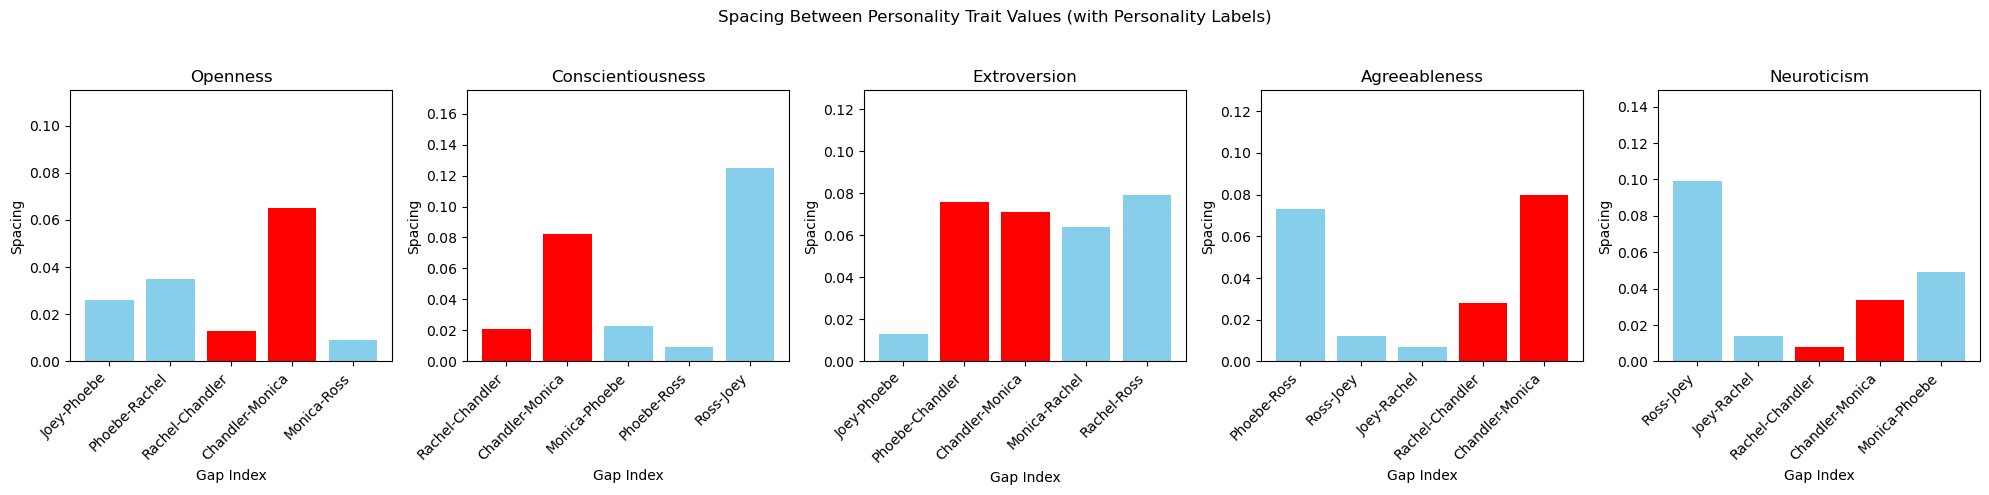

In [ ]:
def plot_trait_spacing_with_labels(personalities, highlight="Chandler"):
    # Convert personalities dictionary to DataFrame
    personalities_df = pd.DataFrame(personalities, index=["Openness", "Conscientiousness", "Extroversion", "Agreeableness", "Neuroticism"])
    
    # Store the spacing data and labels for plotting
    spacing_data = {}
    spacing_labels = {}

    # Loop through each trait and calculate spacing between sorted values
    for trait in personalities_df.index:
        # Sort the values and get corresponding personality names
        sorted_values = personalities_df.loc[trait].sort_values()
        sorted_personalities = sorted_values.index
        
        # Calculate the spacing (differences) between each successive value
        spacing = np.diff(sorted_values.values)
        spacing_data[trait] = spacing
        
        # Generate labels for each gap (who each gap is between)
        labels = [f"{sorted_personalities[i]}-{sorted_personalities[i+1]}" for i in range(len(sorted_personalities) - 1)]
        spacing_labels[trait] = labels

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
    fig.suptitle("Spacing Between Personality Trait Values (with Personality Labels)")

    for idx, (trait, spacing) in enumerate(spacing_data.items()):
        ax = axes[idx]
        
        # Assign colors, with red for bars involving the highlighted personality
        colors = ["red" if highlight in label else "skyblue" for label in spacing_labels[trait]]
        
        # Plot bars with designated colors
        ax.bar(range(len(spacing)), spacing, color=colors)
        ax.set_title(trait)
        ax.set_xlabel("Gap Index")
        ax.set_ylabel("Spacing")
        ax.set_ylim(0, max(spacing) + 0.05)
        
        # Set custom x-tick labels to show which personalities the gaps are between
        ax.set_xticks(range(len(spacing)))
        ax.set_xticklabels(spacing_labels[trait], rotation=45, ha="right")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Example usage
personalities = {
    "Chandler": [0.648, 0.375, 0.386, 0.58, 0.477],
    "Joey": [0.574, 0.614, 0.297, 0.545, 0.455],
    "Monica": [0.713, 0.457, 0.457, 0.66, 0.511],
    "Phoebe": [0.6, 0.48, 0.31, 0.46, 0.56],
    "Rachel": [0.635, 0.354, 0.521, 0.552, 0.469],
    "Ross": [0.722, 0.489, 0.6, 0.533, 0.356]
}

plot_trait_spacing_with_labels(personalities)

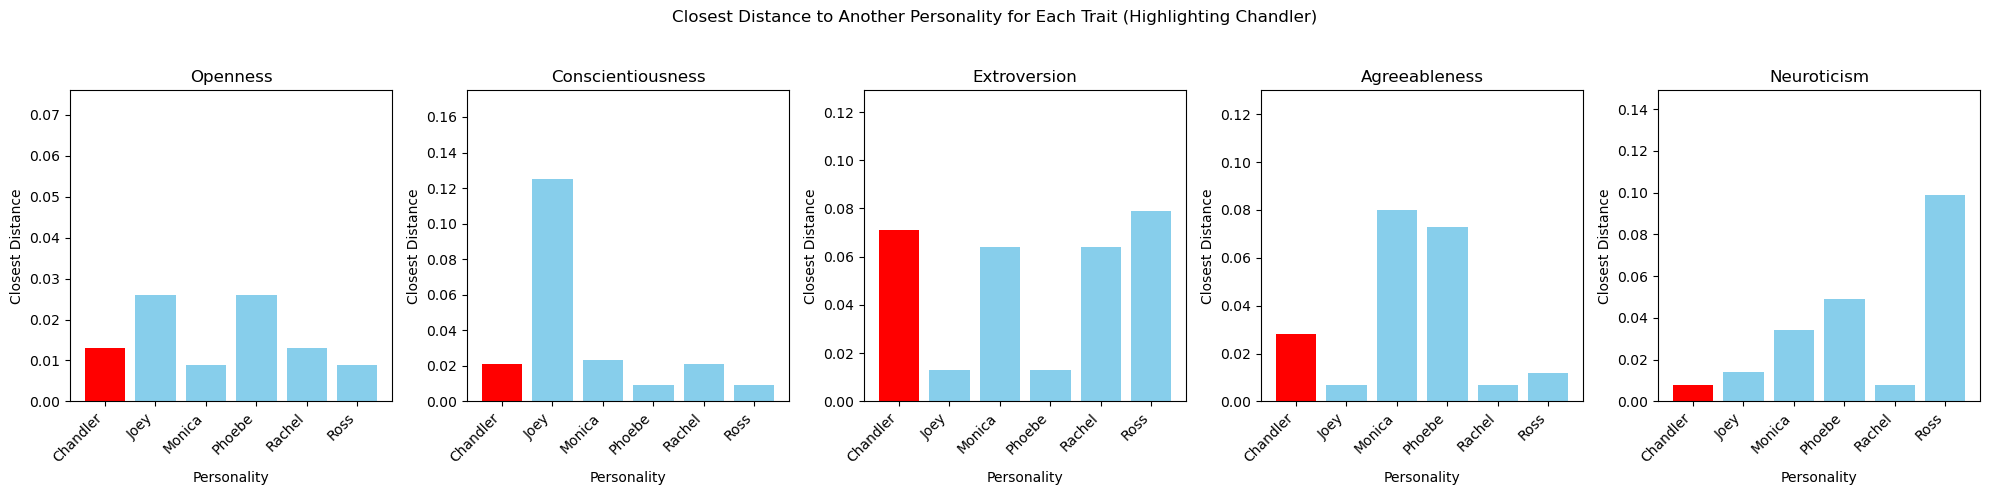

In [ ]:
def plot_closest_distance(personalities, highlight="Chandler"):
    # Convert personalities dictionary to DataFrame
    personalities_df = pd.DataFrame(personalities, index=["Openness", "Conscientiousness", "Extroversion", "Agreeableness", "Neuroticism"])
    
    # Store the closest distances and labels for plotting
    closest_distances = {}
    closest_labels = {}

    # Loop through each personality and calculate the closest distance for each trait
    for personality in personalities_df.columns:
        distances = []
        labels = []
        
        for trait in personalities_df.index:
            # Calculate distances from this personality to all others for the given trait
            current_value = personalities_df.loc[trait, personality]
            other_values = personalities_df.loc[trait].drop(personality)
            abs_distances = np.abs(current_value - other_values)
            
            # Find the closest distance and corresponding personality
            closest_personality = abs_distances.idxmin()
            closest_distance = abs_distances.min()
            distances.append(closest_distance)
            labels.append(f"{personality}-{closest_personality}")
        
        closest_distances[personality] = distances
        closest_labels[personality] = labels

    # Plotting
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
    fig.suptitle("Closest Distance to Another Personality for Each Trait (Highlighting Chandler)")

    for idx, trait in enumerate(personalities_df.index):
        ax = axes[idx]
        
        # Extract the distances and labels for this trait
        distances = [closest_distances[personality][idx] for personality in personalities_df.columns]
        labels = [closest_labels[personality][idx] for personality in personalities_df.columns]
        
        # Customize colors to highlight Chandler
        colors = ["red" if personality == highlight else "skyblue" for personality in personalities_df.columns]
        
        # Plot with custom labels
        ax.bar(range(len(personalities_df.columns)), distances, color=colors)
        ax.set_title(trait)
        ax.set_xlabel("Personality")
        ax.set_ylabel("Closest Distance")
        ax.set_ylim(0, max(distances) + 0.05)
        
        # Set custom x-tick labels with personality names
        ax.set_xticks(range(len(personalities_df.columns)))
        ax.set_xticklabels(personalities_df.columns, rotation=45, ha="right")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


plot_closest_distance(personalities)